# One-dimensional Diffusion Equation

## Problem setup
We will solve a diffusion equation:

$$
\frac{\partial y}{\partial t} = C \frac{\partial^2y}{\partial x^2} - e^{-t}(\sin(\pi x) - \pi^2\sin(\pi x)),   \qquad x \in [-1, 1], \quad t \in [0, 1]
$$

with the initial condition

$$
y(x, 0) = \sin(\pi x)
$$

and the Dirichlet boundary condition

$$
y(-1, t) = y(1, t) = 0.
$$

The reference solution is $y = e^{-t} \sin(\pi x)$.



## Dimensional Analysis


Below is the dimensional analysis of the given **diffusion equation** with an unknown parameter $C$:


### Step 1: Assign Dimensions to Variables

1. **Spatial Coordinate $x$:**
   - Spatial coordinate has the dimension of length:

     $$
     [x] = L.
     $$

2. **Time $t$:**
   - Time has the dimension:

     $$
     [t] = T.
     $$

3. **Function $y(x, t)$:**
   - $y$ is the solution of the diffusion equation and depends on the context. For this case, $y$ has no explicit physical quantity associated with it, but we assume it to be **dimensionless** since the reference solution is given as $ y = e^{-t} \sin(\pi x) $, where both $e^{-t}$ and $\sin(\pi x)$ are dimensionless.

     $$
     [y] = 1 \quad \text{(dimensionless)}.
     $$

4. **Parameter $C$:**
   - The term $C \frac{\partial^2 y}{\partial x^2}$ must have the same dimension as $\frac{\partial y}{\partial t}$ for consistency.

     - First, consider the time derivative:

       $$
       \left[\frac{\partial y}{\partial t}\right] = \frac{[y]}{[t]} = \frac{1}{T}.
       $$

     - Next, consider the second spatial derivative:

       $$
       \left[\frac{\partial^2 y}{\partial x^2}\right] = \frac{[y]}{[x]^2} = \frac{1}{L^2}.
       $$
     - Multiplying by $C$, the dimensions of $C$ must satisfy:

       $$
       [C] \cdot \frac{1}{L^2} = \frac{1}{T} \implies [C] = \frac{L^2}{T}.
       $$

5. **Source Term:** $e^{-t} \left(\sin(\pi x) - \pi^2 \sin(\pi x)\right)$
   - The exponential term $e^{-t}$ and the sine functions are dimensionless. Therefore, the source term is dimensionally consistent with:
   
     $$
     \text{Source Term} = \frac{1}{T}.
     $$

---

### Step 2: Initial and Boundary Conditions

- **Initial Condition:** $y(x, 0) = \sin(\pi x)$.
  - $\sin(\pi x)$ is dimensionless, consistent with $ [y] = 1 $.

- **Boundary Condition:** $y(-1, t) = y(1, t) = 0$.
  - The boundary values are dimensionless.

---

### Step 3: Summary of Dimensions

| Variable/Parameter     | Physical Meaning                   | Dimensions            |
|------------------------|-----------------------------------|-----------------------|
| $x$                  | Spatial coordinate                | $L$                 |
| $t$                  | Time                              | $T$                 |
| $y$                  | Solution (dimensionless)          | $1$                 |
| $C$                  | Diffusion coefficient             | $L^2 / T$           |
| Source term            | Forcing function                  | $1 / T$             |

---

In conclusion,

- The unknown parameter $C$ has dimensions of $L^2 / T$, which is consistent with the physical meaning of a diffusion coefficient.
- The function $y$ and the boundary/initial conditions are dimensionless, ensuring the consistency of the problem setup.


## Implementation

Import the required libraries:

In [1]:
import brainstate as bst
import brainunit as u

import deepxde.experimental as deepxde

Define the physical units for the problem:

In [2]:
unit_of_x = u.meter
unit_of_t = u.second
unit_of_f = 1 / u.second

c = 1. * u.meter ** 2 / u.second

Define the geometry and time domain:

In [3]:
geom = deepxde.geometry.Interval(-1, 1)
timedomain = deepxde.geometry.TimeDomain(0, 1)
geomtime = deepxde.geometry.GeometryXTime(geom, timedomain)
geomtime = geomtime.to_dict_point(x=unit_of_x, t=unit_of_t)


Define the initial condition and boundary condition functions:

In [4]:
def func(x):
    y = u.math.sin(u.math.pi * x['x'] / unit_of_x) * u.math.exp(-x['t'] / unit_of_t)
    return {'y': y}


bc = deepxde.icbc.DirichletBC(func)
ic = deepxde.icbc.IC(func)

Define the neural network model:

In [5]:
net = deepxde.nn.Model(
    deepxde.nn.DictToArray(x=unit_of_x, t=unit_of_t),
    deepxde.nn.FNN([2] + [32] * 3 + [1], "tanh"),
    deepxde.nn.ArrayToDict(y=None),
)

Define the PDE function:

In [6]:
def pde(x, y):
    jacobian = net.jacobian(x, x='t')
    hessian = net.hessian(x, xi='x', xj='x')
    dy_t = jacobian["y"]["t"]
    dy_xx = hessian["y"]["x"]["x"]
    source = (
        u.math.exp(-x['t'] / unit_of_t) * (
        u.math.sin(u.math.pi * x['x'] / unit_of_x) -
        u.math.pi ** 2 * u.math.sin(u.math.pi * x['x'] / unit_of_x)
    )
    )
    return dy_t - c * dy_xx + source * unit_of_f


Define the problem and train the model:

In [7]:
problem = deepxde.problem.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    net,
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    solution=func,
    num_test=10000,
)

Train the model:

Compiling trainer...
'compile' took 0.066982 s

Training trainer...

Step      Train loss                                                   Test loss                                                    Test metric                                       
0         [39.28094 * becquerel2,                                      [42.6258 * becquerel2,                                       [{'y': Array(2.4083016, dtype=float32)}]          
           {'ibc0': {'y': Array(0.82120794, dtype=float32)}},           {'ibc0': {'y': Array(0.82120794, dtype=float32)}},                                                            
           {'ibc1': {'y': Array(1.7334808, dtype=float32)}}]            {'ibc1': {'y': Array(1.7334808, dtype=float32)}}]                                                             
1000      [0.00716378 * becquerel2,                                    [0.03221128 * becquerel2,                                    [{'y': Array(0.08175115, dtype=float32)}]         
           {'ibc

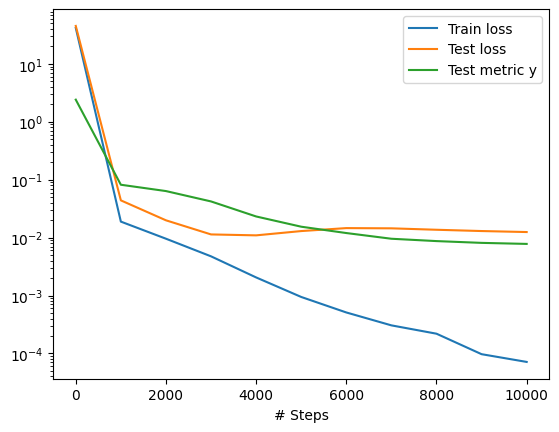

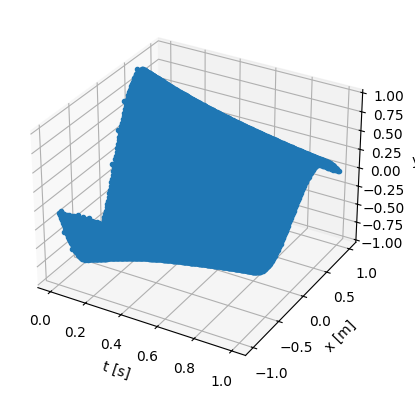

In [8]:
trainer = deepxde.Trainer(problem)
trainer.compile(bst.optim.Adam(0.001), metrics=["l2 relative error"]).train(iterations=10000)
trainer.saveplot(issave=True, isplot=True)
